In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Current Data

In [2]:
np.random.seed(11)
t_current = pd.date_range("01:00:00", "02:00:00", freq="10s")
noise = 0.05 * (np.random.random(len(t_current)) - 0.5)
current = 5 + noise.cumsum()

### Voltage Data

In [3]:
np.random.seed(7)
t_voltage = pd.date_range("01:00:00", "02:00:00", freq="15s") + pd.Timedelta("3s")
noise = 0.1 * (np.random.random(len(t_voltage)) - 0.5)
voltage = 12 + noise.cumsum()

In [4]:
# Make current and voltage dataframes
df_current = pd.DataFrame({"timestamp": t_current, "current": current})
df_voltage = pd.DataFrame({"timestamp": t_voltage, "voltage": voltage})

### Plot Raw Signals

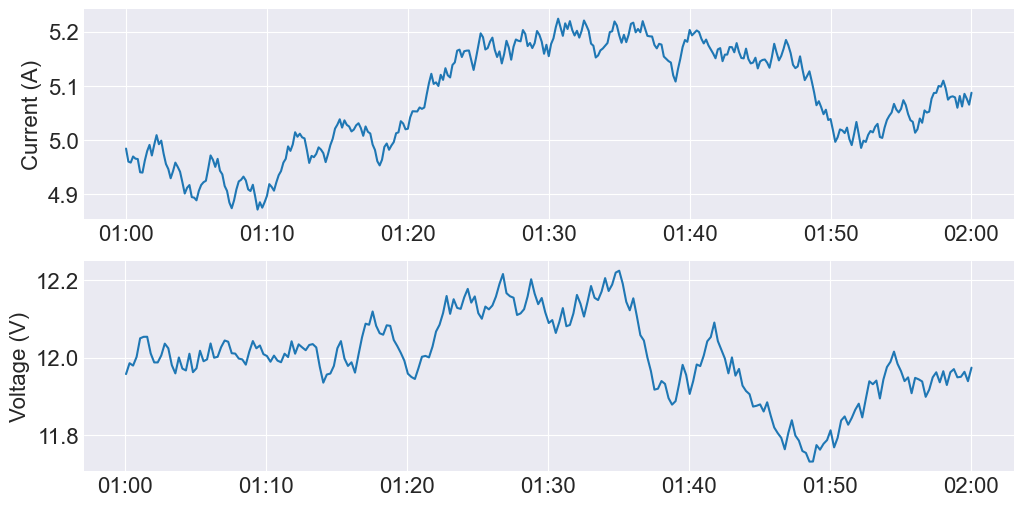

In [6]:
# Plot two signals
plt.style.use("seaborn-darkgrid")
plt.rcParams["font.size"] = 16

# Create subplots and plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
ax1.plot(df_current["timestamp"], df_current["current"])
ax2.plot(df_voltage["timestamp"], df_voltage["voltage"])

# Edit x-tick time format
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Add axis labels
ax1.set(ylabel="Current (A)")
ax2.set(ylabel="Voltage (V)")
plt.show()

### Zoomed in Raw Signal Plots

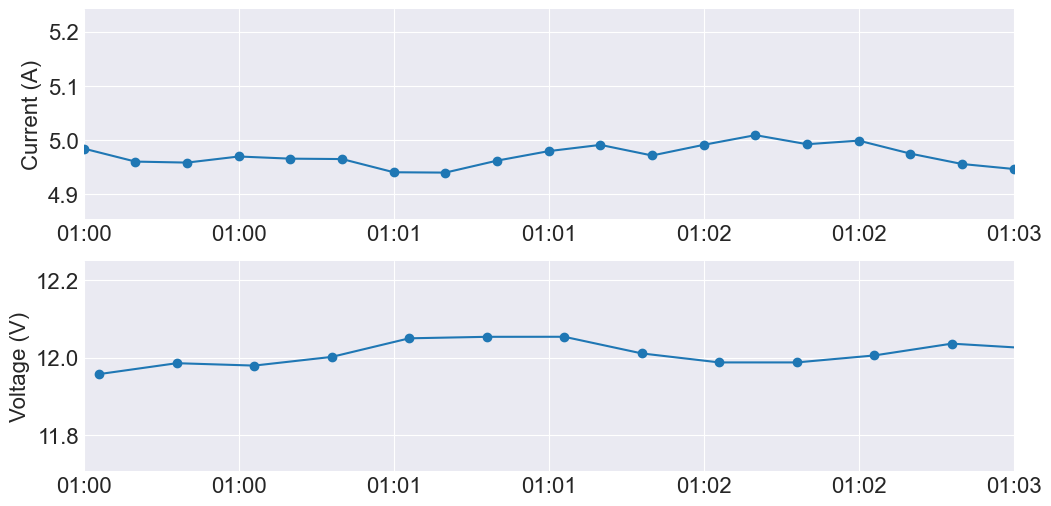

In [7]:
# Plot two signals
plt.style.use("seaborn-darkgrid")
plt.rcParams["font.size"] = 16

# Create subplots and plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
ax1.plot(df_current["timestamp"], df_current["current"], marker="o")
ax2.plot(df_voltage["timestamp"], df_voltage["voltage"], marker="o")

# Edit x-tick time format
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Add axis labels
ax1.set(ylabel="Current (A)", xlim=[pd.Timestamp("01:00:00"), pd.Timestamp("01:03:00")])
ax2.set(ylabel="Voltage (V)", xlim=[pd.Timestamp("01:00:00"), pd.Timestamp("01:03:00")])
plt.show()

### Update and Combine Dataframes

In [8]:
# Update dataframe schemas
df_current["sensor"] = "current"
df_current = df_current.rename(columns={"current": "value"})

df_voltage["sensor"] = "voltage"
df_voltage = df_voltage.rename(columns={"voltage": "value"})

# Combine dataframes
df_sensor = df_current.append(df_voltage)

In [9]:
df_sensor

,timestamp,value,sensor
0,2024-03-13 01:00:00,4.984013,current
1,2024-03-13 01:00:10,4.959987,current
2,2024-03-13 01:00:20,4.958148,current
3,2024-03-13 01:00:30,4.969395,current
4,2024-03-13 01:00:40,4.965405,current
...,...,...,...
236,2024-03-13 01:59:03,11.949298,voltage
237,2024-03-13 01:59:18,11.950622,voltage
238,2024-03-13 01:59:33,11.963508,voltage
239,2024-03-13 01:59:48,11.939366,voltage


### Pivot Dataframe

In [10]:
# Pivot the dataframe
df_sensor_pivot = df_sensor.pivot(index="timestamp", columns="sensor", values="value")

In [11]:
df_sensor_pivot

sensor,current,voltage
timestamp,,
2024-03-13 01:00:00,4.984013,NaN
2024-03-13 01:00:03,NaN,11.957631
2024-03-13 01:00:10,4.959987,NaN
2024-03-13 01:00:18,NaN,11.985623
2024-03-13 01:00:20,4.958148,NaN
...,...,...
2024-03-13 01:59:40,5.075920,NaN
2024-03-13 01:59:48,NaN,11.939366
2024-03-13 01:59:50,5.065012,NaN


### Forward Fill Strategy

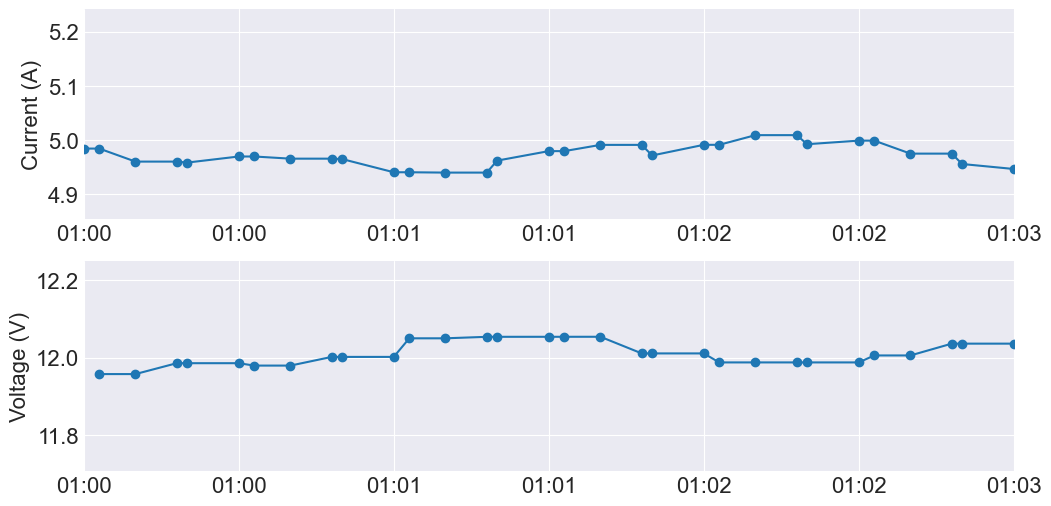

In [12]:
# Forward fill data
df_sensor_pivot = df_sensor_pivot.ffill()

# Create subplots and plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
ax1.plot(df_sensor_pivot["current"], marker="o")
ax2.plot(df_sensor_pivot["voltage"], marker="o")

# Edit x-tick time format
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Add axis labels
ax1.set(ylabel="Current (A)", xlim=[pd.Timestamp("01:00:00"), pd.Timestamp("01:03:00")])
ax2.set(ylabel="Voltage (V)", xlim=[pd.Timestamp("01:00:00"), pd.Timestamp("01:03:00")])
plt.show()

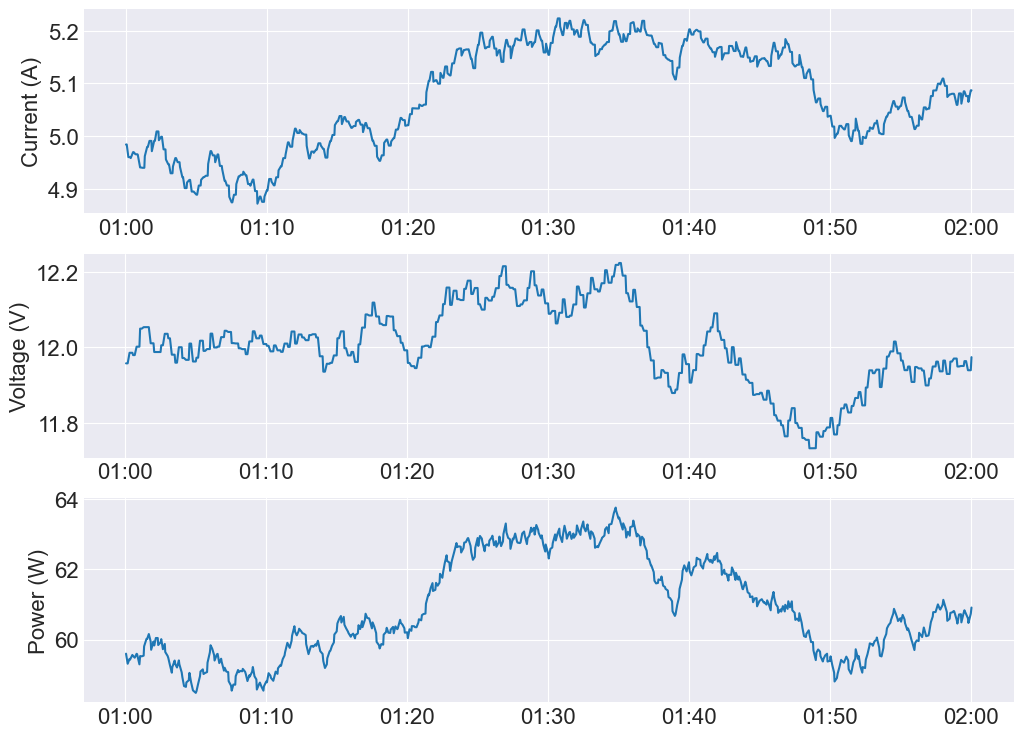

In [13]:
# Calculate Power
df_sensor_pivot["power"] = df_sensor_pivot["current"] * df_sensor_pivot["voltage"]

# Create subplots and plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
ax1.plot(df_sensor_pivot["current"])
ax2.plot(df_sensor_pivot["voltage"])
ax3.plot(df_sensor_pivot["power"])

# Edit x-tick time format
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Add axis labels
ax1.set(ylabel="Current (A)")
ax2.set(ylabel="Voltage (V)")
ax3.set(ylabel="Power (W)")
plt.show()

In [14]:
# Reset index to get timestamp column
df_sensor_pivot = df_sensor_pivot.reset_index()

# Get average of consecutive values
df_sensor_pivot["midpoint"] = (df_sensor_pivot["power"] + df_sensor_pivot["power"].shift()) / 2

# Get the time difference between rows
df_sensor_pivot["time_diff"] = (df_sensor_pivot["timestamp"] - df_sensor_pivot["timestamp"].shift()).apply(lambda t: t.total_seconds())

# Calculate the area of the trapezoid
df_sensor_pivot["energy_kJ"] = df_sensor_pivot["midpoint"] * df_sensor_pivot["time_diff"] / 1000

In [15]:
print(f"Energy: {df_sensor_pivot['energy_kJ'].sum().round(3)} kJ")

Energy: 219.233 kJ


### Resampling Strategy

In [16]:
# Pivot the dataframe
df_sensor_pivot = df_sensor.pivot(index="timestamp", columns="sensor", values="value")

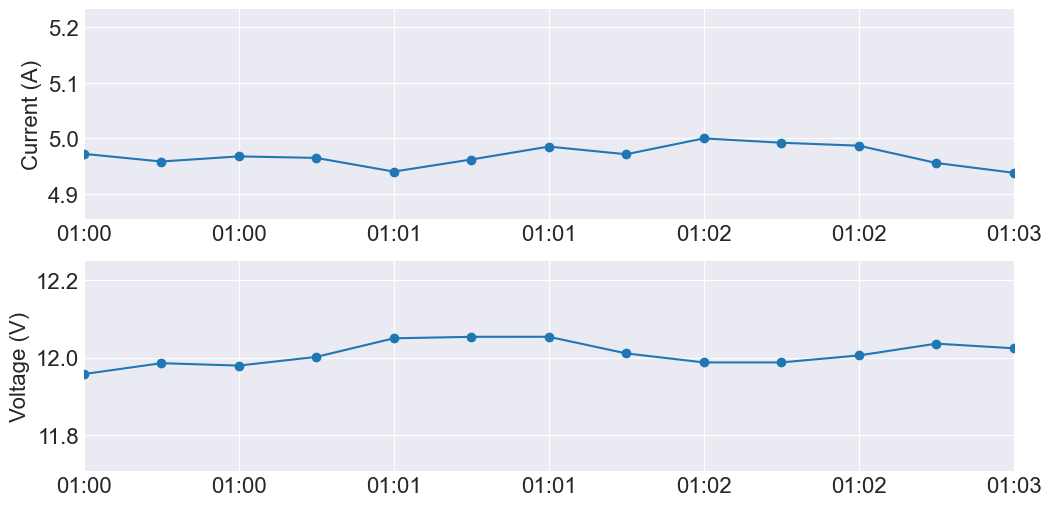

In [17]:
# Resample our dataframe to 15 seconds
df_sensor_pivot = df_sensor_pivot.resample("15s").mean()

# Create subplots and plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
ax1.plot(df_sensor_pivot["current"], marker="o")
ax2.plot(df_sensor_pivot["voltage"], marker="o")

# Edit x-tick time format
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Add axis labels
ax1.set(ylabel="Current (A)", xlim=[pd.Timestamp("01:00:00"), pd.Timestamp("01:03:00")])
ax2.set(ylabel="Voltage (V)", xlim=[pd.Timestamp("01:00:00"), pd.Timestamp("01:03:00")])
plt.show()

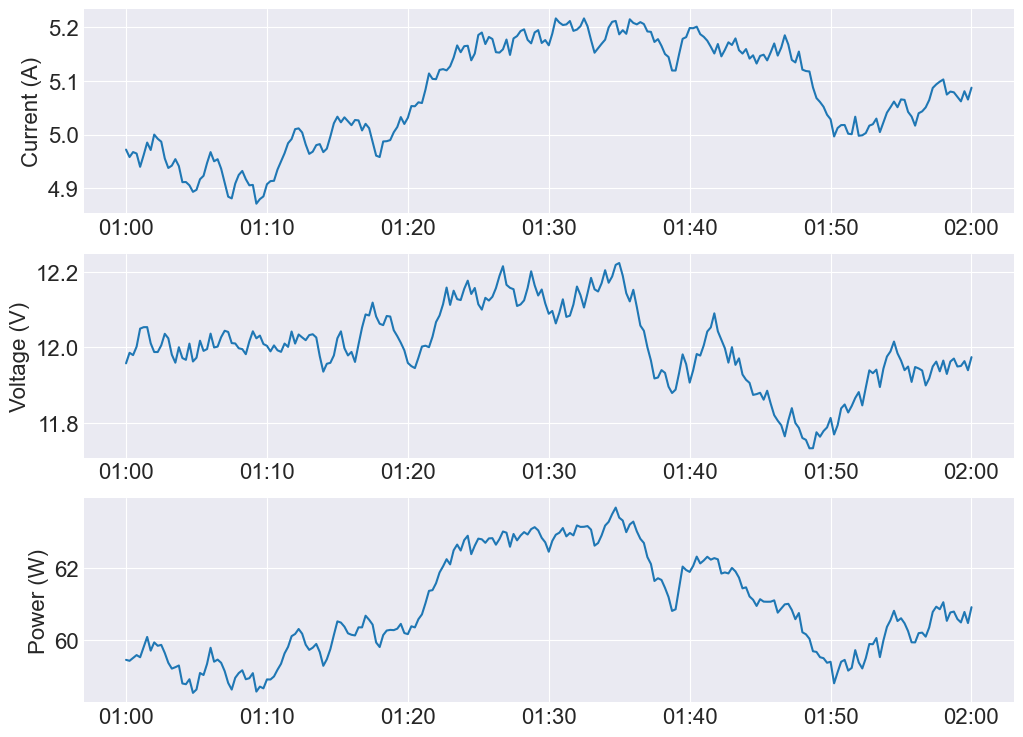

In [18]:
# Calculate Power
df_sensor_pivot["power"] = df_sensor_pivot["current"] * df_sensor_pivot["voltage"]

# Create subplots and plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
ax1.plot(df_sensor_pivot["current"])
ax2.plot(df_sensor_pivot["voltage"])
ax3.plot(df_sensor_pivot["power"])

# Edit x-tick time format
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Add axis labels
ax1.set(ylabel="Current (A)")
ax2.set(ylabel="Voltage (V)")
ax3.set(ylabel="Power (W)")
plt.show()

In [19]:
# Reset index to get timestamp column
df_sensor_pivot = df_sensor_pivot.reset_index()

# Get average of consecutive values
df_sensor_pivot["midpoint"] = (df_sensor_pivot["power"] + df_sensor_pivot["power"].shift()) / 2

# Get the time difference between rows
df_sensor_pivot["time_diff"] = (df_sensor_pivot["timestamp"] - df_sensor_pivot["timestamp"].shift()).apply(lambda t: t.total_seconds())

# Calculate the area of the trapezoid
df_sensor_pivot["energy_kJ"] = df_sensor_pivot["midpoint"] * df_sensor_pivot["time_diff"] / 1000

In [20]:
print(f"Energy: {df_sensor_pivot['energy_kJ'].sum().round(3)} kJ")

Energy: 219.229 kJ
